# Analyse Experiment Data 4

With pressure sensor parascientific and new sensor 

In [15]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
config = {}

In [17]:
config['datapath_femto'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/femto/experiment2/"

## read data stream using obspy routine
st = obs.read(config['datapath_femto']+"munki1.263.264.css.wfdisc", format="CSS")

## merge traces that might be split due to data gaps or overlaps
st.merge()

## setting the calibration variable if not already set
st[0].stats.calib = 1.0

## show all traces in data stream
st

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/core/trace.py:220: UserWarning: Calibration factor set to 0.0!
  warnings.warn(msg, UserWarning)


1 Trace(s) in Stream:
.munki1..p1s32 | 2022-09-19T23:43:50.069720Z - 2022-09-21T18:46:38.019720Z | 20.0 Hz, 3099360 samples

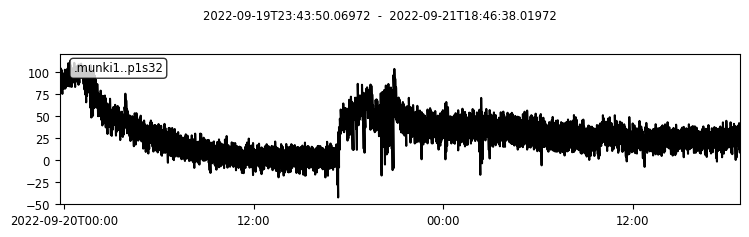

In [18]:
st.plot(equal_scale=False);

## Experiment Valve closed

Read pressure data

In [19]:
config['datapath_pressure'] = "/home/andbro/Documents/ROMY/Scripps_Fiber/data/pressure/"

In [20]:
## read data of parascientific barometer
pressure = pd.read_csv(config['datapath_pressure']+"DATA4.txt", names=["timestamp","pressure"])

## convert timestamp to datetime objects
pressure['timestamp'] = pd.to_datetime(pressure.timestamp)

## make local time to UTC (+7 hours)
pressure['timestamp'] += pd.to_timedelta(7, unit='h')

## resample with df=1sec
pressure = pressure.resample("1S", on="timestamp").mean().reset_index()

pressure

,timestamp,pressure
0,2022-09-21 02:25:28,101.401100
1,2022-09-21 02:25:29,101.572200
2,2022-09-21 02:25:30,101.388800
3,2022-09-21 02:25:31,100.881400
4,2022-09-21 02:25:32,100.331800
...,...,...
24820,2022-09-21 09:19:08,101.181700
24821,2022-09-21 09:19:09,100.628950
24822,2022-09-21 09:19:10,100.290750
24823,2022-09-21 09:19:11,100.244867


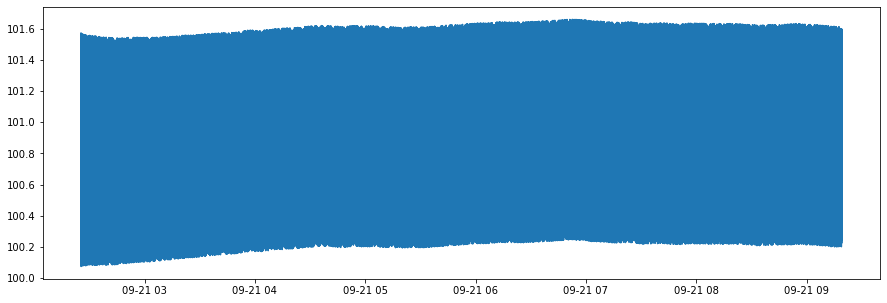

In [21]:
plt.figure(figsize=(15,5))
plt.plot(pressure.timestamp, pressure.pressure)

.BARO..XXX | 2022-09-21T02:25:28.000000Z - 2022-09-21T09:19:12.000000Z | 1.0 Hz, 24825 samples


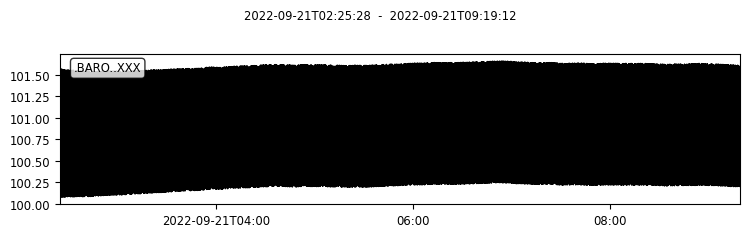

In [22]:
pressure_trace = obs.Trace()

pressure_trace.data = np.array(pressure.pressure)
pressure_trace.stats.starttime = obs.UTCDateTime(pressure.timestamp[0])
pressure_trace.stats.delta = 1.0
pressure_trace.stats.station = "BARO"
pressure_trace.stats.channel = "XXX"

print(pressure_trace)

pressure_trace.plot();

Text(0, 0.5, 'Pressure (kPa)')

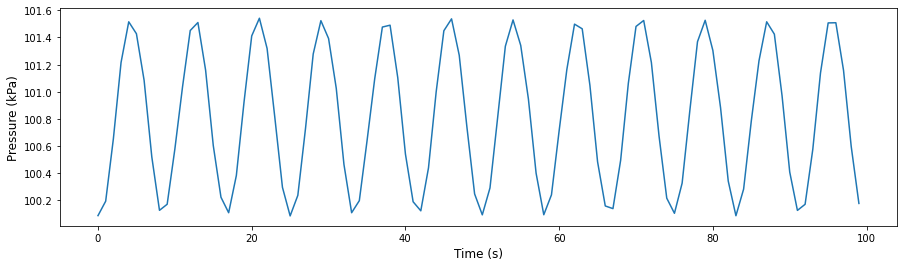

In [23]:
plt.figure(figsize=(15,4))
plt.plot(pressure_trace.data[1000:1100])
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Pressure (kPa)", fontsize=12)

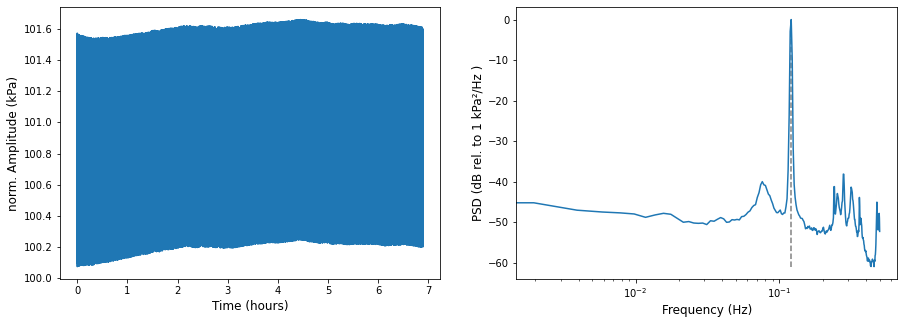

In [24]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data 
    
    nblock =  512
    overlap = None
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)

    ## normalize
    # Pxx /= nblock

    
    Pxx /= max(Pxx)
    Pxx = 10*np.log10(Pxx)

    
    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(0.120, min(Pxx), max(Pxx), color="grey", ls="--", alpha=1, zorder=0)
    ax[1].semilogx(f, Pxx)

#     ax[1].set_ylim(-80,5)
#     ax[1].set_xlim(1e-3,5)

    ax[0].set_xlabel("Time (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_ylabel("norm. Amplitude (kPa)", fontsize=font)
    ax[1].set_ylabel("PSD (dB rel. to 1 kPa²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(pressure_trace)

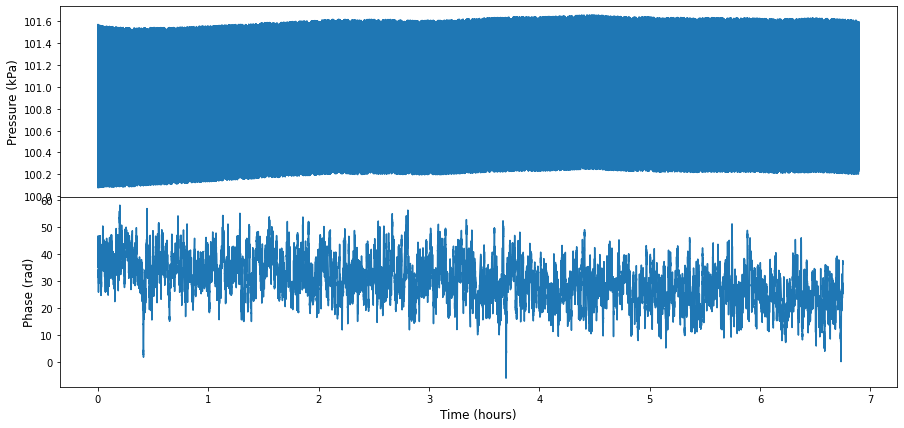

In [25]:
st2 = st.copy()

t1 = obs.UTCDateTime("2022-09-21 02:30")
t2 = obs.UTCDateTime("2022-09-21 09:15")

st2.trim(t1, t2)

# st2.plot(equal_scale=False);


## add pressure trace
st2 += pressure_trace


def __make_plot_traces():

    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)

    fig.subplots_adjust(hspace=0)

    ax[0].plot(st2.select(station="BARO")[0].times()/3600, st2.select(station="BARO")[0].data)
    ax[1].plot(st2.select(station="munki1")[0].times()/3600, st2.select(station="munki1")[0].data)

    plt.xlabel("Time (hours)", fontsize=12)
    ax[0].set_ylabel("Pressure (kPa)", fontsize=12)
    ax[1].set_ylabel("Phase (rad)", fontsize=12)

__make_plot_traces()

In [26]:

# st2.detrend('polynomial', order=2)
# st2.taper(0.1)

# st2.filter('highpass', freq=0.05, corners=4, zerophase=True)
# st2.filter('bandpass', freqmin=0.09, freqmax=0.2, corners=4, zerophase=True)

# st2.plot(equal_scale=False);

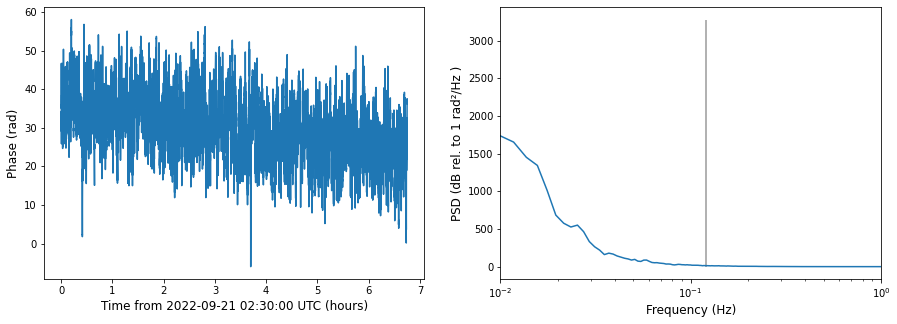

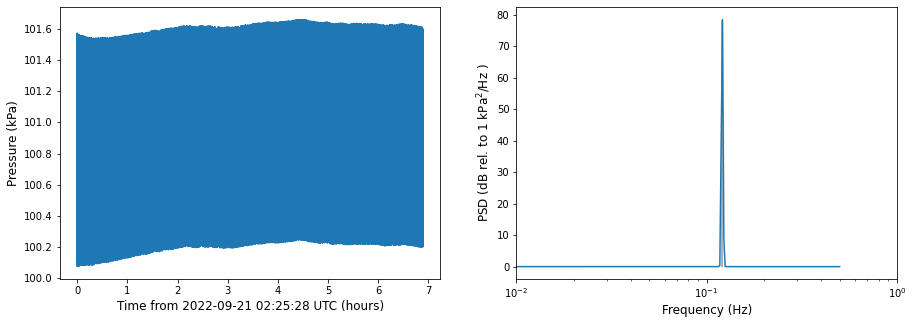

In [27]:
def __plot_psd(trace):

    from scipy.signal import welch, hann


    signal = trace.data

    signal = [el if not np.isnan(el) else 0 for el in signal ]
    
    tstart = trace.stats.starttime
    
    nblock =  512*trace.stats.sampling_rate
    overlap = int(nblock /2)
    # window = hann(int(nblock))

    f, Pxx = welch(signal, fs=trace.stats.sampling_rate, 
                    window='hann', noverlap=overlap, nperseg=nblock,
                    scaling="density",
                    return_onesided=True)
    ## normalize
    # Pxx /= nblock

#     Pxx /= max(Pxx)
#     Pxx = 10*np.log10(Pxx)


    ## ------------------------

    font = 12

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    tx = np.linspace(0, trace.stats.npts/trace.stats.sampling_rate/3600, trace.stats.npts)
    ax[0].plot(tx, signal)

    ax[1].vlines(0.120, min(Pxx), max(Pxx), color="grey", ls="-", alpha=0.8, zorder=0)
    ax[1].plot(f, Pxx)

    
    ax[1].set_xscale("log")
#     ax[1].set_ylim(-80,0)
    ax[1].set_xlim(1e-2,1)

    ax[0].set_xlabel(f"Time from {tstart.date} {str(tstart.time)[:8]} UTC (hours)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    
    
    if trace.stats.station == "BARO":
        ax[0].set_ylabel("Pressure (kPa)", fontsize=font)
        ax[1].set_ylabel(r"PSD (dB rel. to 1 kPa$^2$/Hz )", fontsize=font)

    elif trace.stats.station == "munki1":
        ax[0].set_ylabel("Phase (rad)", fontsize=font)
        ax[1].set_ylabel("PSD (dB rel. to 1 rad²/Hz )", fontsize=font)

    plt.show();
    
__plot_psd(st2.select(station="munki1")[0])
__plot_psd(st2.select(station="BARO")[0])

In [28]:
signal = pressure_trace.data

from andbro__get_mean_amplitude import __get_mean_amplitude

# def __get_mean_amplitude(signal, deltaN=100):

#     from numpy import mean, std

#     n1, n2, amplitudes = 0, deltaN, []

#     while n2 < len(signal):

#         amplitudes.append(max(signal[n1:n2])-min(signal[n1:n2]))

#         n1 += deltaN
#         n2 += deltaN

#     return amplitudes, mean(amplitudes), std(amplitudes)

amps, amps_mean, amps_std = __get_mean_amplitude(signal, deltaN=100)

ModuleNotFoundError: No module named 'andbro__get_mean_amplitude'

In [ ]:
plt.hist(amps)

np.mean(amps), np.std(amps)